# Проектная работа

# Анализ отточных пользователей облачного сервиса для автоматизации управления строительством и ремонтом

**Описание проекта**

Заказчик – облачный сервис для автоматизации управления строительством и ремонтом.
Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.
Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.
 
**Цель проекта**

Проанализировать имеющиеся данные, составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации. Для этого предлагается определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки.
 
**Задачи**

1. Провести исследовательский анализ данных;
2. Сформулировать и проверить гипотезы, основываясь на имеющихся признаках;
3. Формулирование выводов по полученным результатам, подготовка презентации.
 
**Описание данных**

Для работы представлено 4 файла с описанием компаний и их сотрудников: роли, количество работающих в системе, количество совершенных действий по месяцам и прочая информация.

1. [**Знакомство с данными и предобработка**](#start)
    - Ознакомиться с содержимым таблиц
    - Выявить колонки изначения которые необходимо преобразовать и т.д.
    - Найти пропуски, явные или неявные дубликаты, принять решение об их удалении/обработке
    
2. [**Исследовательский анализ данных (EDA)**](#eda) 

    - Построить графики распределения клиентов по врем признакам, в том числе в разрезе оттока
    - Провести анализ корреляций среди различных признаков 
    - Составить портрет отточных клиентов

3. [**Проверка статистических гипотез**](#stats)

        
4. [**Выводы и базовые рекомендации по работе с клиентами**](#end)
    - Сформулировать основные выводы.
    - Предложить рекомендации для сервиса. 

## Знакомство с данными и предобработка<a id="start"></a>

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
from datetime import datetime
import scipy.stats as st
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

Функция для вывеения информации о датасетах:

In [2]:
def gen(df):
    print('======Информация======')
    df.info()
    for column in df.columns:
        print('')
        print('=== Уникальные значения столбца', column, ": ===")
        print(df[column].unique())
        print('')
        print('=== Количество уникальных значений столбца', column, ": ===")
        print(df[column].nunique())
        print('')
        print('=== Количество значений столбца', column, ": ===")
        print(df[column].value_counts())
        print('')
        
    print('== Пропуски ==')
    count=0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, '-', df[element].isna().sum(), 'пропусков')
            count=+1
    if count ==0:
        print('Пропусков нет')
    print('')
    print('== Дубликаты ==')
    if df.duplicated().sum() > 0:

        print('Дубликатов', df.duplicated().sum())
    else:
        print('Дубликатов нет')

Выгружаем датасеты:

In [3]:
bill = pd.read_csv('billing.csv',index_col=0, sep=',')
bill = bill.drop(columns='Unnamed: 0')

act = pd.read_csv('activities.csv',index_col=0, sep=',')

ppl = pd.read_csv('people.csv',index_col=0, sep=',')
ppl = ppl.drop(columns='id')

cmp = pd.read_csv('companies.csv',index_col=0, sep=',')

Первый файл с активностями компаний. Ознакомимся с содержанием файла:

**Файл активностей `activities.csv`.**

Сгруппирован по компаниям, отсортирован по компаниям, а в пределах каждой компании - по месяцам

* `company_id` - идентификатор компании
* `month` - отчетный месяц
* `company-month-billing` - количество счетов, выставленных в приложении, компанией за месяц
* `company-month-stocks` - месячное количество складов (аренда, заказы и т.д.), используемых компанией
* `company-month-backups` - месячное количество бэкапов компании
* `company-month-projects` - месячное количество проектов компании
* `company-month-contractors` - месячное количество контрагентов компании
* `company-month-resource_orders` - месячное количество заказов материалов компании

In [4]:
act.head()

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


Применяем функцию для вывода информации о файле:

In [5]:
gen(act.iloc[:,[0,2,3,4,5,7]])

======Информация======
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6316 entries, 0 to 6556
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_id                     6316 non-null   int64  
 1   company-month-billing          6316 non-null   float64
 2   company-month-stocks           6316 non-null   float64
 3   company-month-backups          6316 non-null   float64
 4   company-month-projects         6316 non-null   float64
 5   company-month-resource_orders  6316 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 345.4 KB

=== Уникальные значения столбца company_id : ===
[   1   21   30  108  116  218  257  303  309  336  344  347  366  383
  408  419  421  430  457  468  471  483  495  496  502  512  514  541
  575  589  602  622  628  639  650  667  688  694  720  724  726  738
  749  765  822  845  858  860  865  874  877  882  885  905  912  919
  920

- в файле 6316 строк, из них уникальных ID компаний - 716
- данные представлены за 63 месяца, с 2019 по 2024 год
- во всех колонках наиболее часто встречающееся значение это 0
- пропусков в таблице нет, явных дубликатов тоже 

Преобразуем данные в колонке с месяцами, чтобы там остались только даты

In [6]:
act['month'] = pd.to_datetime(act['month'])
act['month'] = act['month'].dt.strftime('%Y-%m-%d')
act['month'] = pd.to_datetime(act['month'], utc=False)

Также переименуем названия колонок в более короткие, чтобы к ним было удобнее обращаться, и изменим значения в них на целочисленные.

In [7]:
act = act.rename(columns={'company-month-billing': 'billing', 'company-month-stocks': 'stocks',
                         'company-month-backups': 'backups', 'company-month-projects': 'projects',
                         'company-month-contractors': 'contractors', 'company-month-resource_orders': 'orders'})\
.astype({'billing':int, 'stocks':int, 'backups':int, 'projects':int, 'contractors':int, 'orders':int})

Ознакомимся с датасетом по платежам компаний

**Файл платежей `billing.csv`**

* `unnamed:0` - старый индекс
* `user_id` - идентификатор пользователя
* `company_id` - идентификатор компании пользователя
* `billing_tariff_id` - тарифный план
    -  тарифы 1, 18, 22 - тестовые, бесплатные и пробные. Если такие есть - при анализе не должны использоваться. для остальных тарифов - основное различие - разное количество пользователей
    - тарифы 4, 7, 8, 11, 19 - группа “старт”
    - тарифы 2, 17 - группа “базовый”
    - тарифы 9, 20 - группа “бизнес”
    - тарифы 3, 10, 13, 21 - группа “Профи”
    - тариф 6 - “архивный”, в настоящее время не используется
* `payed_until` -  дата, до которой подписка компании действует
* `is_payed` - статус оплаты
* `created_at` - дата создания
* `updated_at` - дата обновления
* `billing_tariff_price_id` - id стоимости тарифа (в разное время или для разных клиентов  один и тот же тариф может стоить по-разному)
* `comment` - комментарии
* `pay_date` - дата платежа

In [8]:
bill.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


Изменим формат колонок с датами и ознакомимся с содержимым:

In [9]:
bill[['created_at', 'updated_at','pay_date', 'payed_until']] = \
bill[['created_at', 'updated_at','pay_date','payed_until']].apply(pd.to_datetime, unit='s')

In [10]:
gen(bill.iloc[:,[1,2,3,5,8]])

======Информация======
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3480 entries, 4 to 18953
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  3480 non-null   int64  
 1   company_id               3480 non-null   int64  
 2   billing_tariff_id        3480 non-null   int64  
 3   is_payed                 3480 non-null   bool   
 4   billing_tariff_price_id  3480 non-null   float64
dtypes: bool(1), float64(1), int64(3)
memory usage: 139.3 KB

=== Уникальные значения столбца user_id : ===
[  567  2861  1902 ... 13722 14517 13060]

=== Количество уникальных значений столбца user_id : ===
1841

=== Количество значений столбца user_id : ===
3942     61
4980     40
6        31
9179     30
3924     29
         ..
3224      1
6498      1
6492      1
6332      1
13060     1
Name: user_id, Length: 1841, dtype: int64


=== Уникальные значения столбца company_id : ===
[  512 

- В датасете 3480 строк
- уникальных значений столбца `user_id` всего 1841 - столько же, сколько и `company_id`
- всего 13 разных тарифов компаний, из них тарифы 2 и 7 встречаются чаще других
- уникальных тарифов оплат всего 47
- также есть колонка с комментариями, вероятно, вводимыми вручную. Значение цифр в начале каждого комментария нам неизвестно, они могут означать количество месяцев подписки, тариф компании, номер тарифа оплаты и т.д. 650 уникальных значений, из них несколько повторяющихся - "18+2" - 35шт, "12+1" - 22шт, "24+4" - 9шт, "12+2" - 7шт и "18+2 мес" - 5шт. Вероятно, это пометки о длительности подписки и её продления.
- 2735 пропусков в колонке `comment` - комментарии вводились не всегда
- 2372 пропуска в колонке `pay_date` - оплата производилась не всегда или было ожидание оплаты

Напишем функцию для распределения тарифов компаний по категориям:

In [11]:
def cat(tariff):
    if tariff in [4, 7, 8, 11, 19]:
        return 'Старт'
    elif tariff in [2, 17]:
        return 'Базовый'
    elif tariff in [9, 20]:
        return 'Бизнес'
    elif tariff in [3, 10, 13, 21]:
        return 'Профи'
    elif tariff == 6:
        return 'Архивный'
    else:
        return 'Неизвестный'

Применим функцию к столбцу `billing_tariff_id`, и уберем символы переноса строк в комментариях

In [12]:
bill['tariff'] = bill['billing_tariff_id'].apply(cat)
bill['comment'] = bill['comment'].str.replace(r'\r\n', '. ', regex=True) 

In [13]:
bill['updated_m'] = bill['updated_at'].dt.strftime('%Y-%m-%d')
bill['updated_m'] = pd.to_datetime(bill['updated_m'],utc=False).dt.to_period('M').dt.to_timestamp()

Посмотрим на таблицу с информацией о компаниях:

**Файл компаний `companies.csv`**

* `id` - id компании
* `working_direction` - сфера деятельности
* `employer_count_interval` - id количества сотрудников по возрастающей id от 1 до 8, количество сотрудников - (1-4, 5-10, 11-20, 21-30, 31-50, 51-100, 101-200, >201)
* `created_at` - дата создания компании в системе
* `updated_at` - дата обновления информации о компании
* `billing_tariff_id` - id тарифа 
* `billing_is_over` - истекла ли оплата

In [14]:
cmp.head()

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,1571316635,1670298314,4.0,True
57,383,Строительство,2.0,1564142565,1676550050,7.0,False
69,495,-,1.0,1570535695,1598281714,2.0,False
75,724,-,1.0,1579514393,1670298294,4.0,True
99,471,-,1.0,1569328017,1670298360,7.0,True


Поменяем тип в колонках с датами и выведем информацию:

In [15]:
cmp[['created_at', 'updated_at']] = cmp[['created_at', 'updated_at']].apply(pd.to_datetime, unit='s')

In [16]:
gen(cmp.iloc[:,[1,2,5,6]])

======Информация======
<class 'pandas.core.frame.DataFrame'>
Int64Index: 723 entries, 19 to 17972
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   working_direction        720 non-null    object 
 1   employer_count_interval  723 non-null    float64
 2   billing_tariff_id        716 non-null    float64
 3   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 23.3+ KB

=== Уникальные значения столбца working_direction : ===
['-' 'Строительство' 'Генеральный подрядчик' 'Строительная компания'
 'Ремонт помещений' 'строительство ' 'ремонт и отделка' 'СТРОИТЕЛЬСТВО'
 'строительство' 'Строительство домов' 'телемаркетинг' 'ремонт'
 'Ремонт и отделка помещений' '-Малоэтажное строительство' 'Отделка '
 'Отделка' 'Проектирование и строительство ресторанов '
 'строительство  и отделка' 'ремонты' 'Электромонтажные работы'
 'строительная компания (тест)' 

- в таблице 723 строки, из них уникальных значений по ID компаний так же 723
- в столбце `working_direction` разрозненные значения - вероятно указывались самими компаниями вручную, самые часто встречающиеся - "строительство" и "-"
- в id количества сотрудников 8 уникальных значений, чаще всего встречается 1 и 2
- 13 уникальных значений в `billing_tariff_id`, чаще всего встречаются тарифы 2 и 7
- 3 пропуска в `working_direction` - вероятно, какая-то компания проигнорировала момент заполнения этого поля
- 7 пропусков в `billing_tariff_id` - либо ошибка системы, либо регистрация аккаунта была прервана до выбора тарифа или во время

Функция для разбивки по категориям количества работников

In [17]:
def employee(row):
    if row == 1:
        return '1-4'
    elif row == 2:
        return '5-10'
    elif row == 3:
        return '11-20'
    elif row == 4:
        return '21-30'
    elif row == 5:
        return '31-50'
    elif row == 6:
        return '51-100'
    elif row == 7:
        return '101-200'
    elif row == 8:
        return '>201'
    else:
        return 'Неизвестно'

Применяем функции, и категоризируем колонки с тарифами и сферой деятельности компаний - обрабатываем наиболее часто встречающиеся значения колонки - слово "строительство" приводим к единому виду, "-" и пропуски заменяем на "неизвестно". Также переименовываем столбец с id компаний.

In [18]:
cmp['tariff'] = cmp['billing_tariff_id'].apply(cat)
cmp['employers'] = cmp['employer_count_interval'].apply(employee)
cmp['working_direction'] = cmp['working_direction']\
.replace(['строительство', 'стройтельство', '-строительство', 'Строительство ', 'СТРОИТЕЛЬСТВО'], 'Строительство')
cmp['working_direction'] = cmp['working_direction'].str.strip('- ')
cmp['working_direction'] = cmp['working_direction'].replace(['-',''],'неизвестно')
cmp['working_direction'] = cmp['working_direction'].fillna('неизвестно')
cmp.rename(columns={'id':'company_id'}, inplace=True)

Посмотрим на файл с сотрудниками:

**Файл сотрудников `people.csv`**

* `id` - индекс
* `company_id` - id компании
* `user_id` - id пользователя
* `role_id` - id роли (должности)
* `created_at` - дата создания пользователя
* `updated_at` - дата обновления информации о пользователе
* `is_deleted` - удален ли пользователь
* `deleted_at` - дата удаления

In [19]:
ppl.head()

,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
2,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
6,1,NaN,1,1594120484,1594120484,True,1.594120e+09
7,1255,1734.0,18085,1595438102,1595439391,True,1.633960e+09
10,1470,1703.0,1,1595234824,1595234824,False,NaN
17,1492,1731.0,1,1595429211,1598540644,True,1.620195e+09


Редактируем колонки со временем и выводим информацию:

In [20]:
ppl[['created_at', 'updated_at','deleted_at']] = ppl[['created_at', 'updated_at','deleted_at']].apply(pd.to_datetime, unit='s')

In [21]:
gen(ppl)

======Информация======
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5095 entries, 2 to 17054
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   company_id  5095 non-null   int64         
 1   user_id     3813 non-null   float64       
 2   role_id     5095 non-null   int64         
 3   created_at  5095 non-null   datetime64[ns]
 4   updated_at  5095 non-null   datetime64[ns]
 5   is_deleted  5095 non-null   bool          
 6   deleted_at  2180 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), float64(1), int64(2)
memory usage: 283.6 KB

=== Уникальные значения столбца company_id : ===
[ 495    1 1255 1470 1492 1317  667 1330 1184  116  366 1451 1463  926
 1464 1056  694 1133  924  738  885 2182 1442 2128 1848 1043 1975  920
 2626 2635 2731 1935 2774 2798 2800 2567 2631 1405 1513 1250 1523 1528
 1071 1536  471 1210 1277 1325  860  575  628 3668 1502 2409 2265 2035
 1730 2431 2441 2298 222

- в файле 5095 строк, из них уникальных `company_id` - 712, `user_id` - 3528
- по `role_id` уникальных значений 1411, из них роль "1" встречается чаще всего - 1602 раза
- `user_id` - 1282 пропусков - возможно, id компании может быть использовано вместо id пользователя, особенно, если компания содержит 1-4 сотрудника
- `deleted_at` - 2915 пропусков означает, что какие-то данные не были удалены
- также в таблице 7 дубликатов

Мы имеем данные за 2019-2024 годы о платежах 1841 компании, и дополнительные датасеты, содержащие информацио о сотрудниках, проектах и другую информацию об интересующих нас компаниях, которых примерно 720.

Ознакомление с информацией, содержащейся в датасетах и предварительный анализ позволил выявить основные очевидные моменты:

- Данные представлены за 2019-2024 год
- Пользователи сами вписывают род своей деятельности, что приводит к невозможности как-либо их классифицировать.
- Комментарии по работе с пользователями также вписываются вручную.
- Не ясно, по какому принципу и кем распределяются роли компаний, и что значат цифры, содержащиеся в этой графе. Известно только, что ролей 1411, а цифра 1 встречается 1602 раза из 3,5 тыс, это половина датасета.
- В id количества сотрудников 8 уникальных значеий, чаще всего встречается 1 и 2, что говорит о том, что основными пользователями сервиса являются компании где 1-4 или 5-10 сотрудников.

- Уникальных ценовых тарифов всего 47, но что они значат, и по какому принципу присуждаются, мы не знаем. Можно только предположить, что такие идентификаторы цен могут представлять собой уникальные ключи, используемые для идентификации различных ценовых планов или тарифов, которые могут быть связаны с идентификаторами тарифов, но не обязательно напрямую. Это может быть связано с тем, что сервис использует свою систему ценообразования, где каждый тариф может иметь несколько ценовых планов, каждый из которых имеет свой уникальный идентификатор.

  - Таким образом, данные в этой колонке могут быть связаны с различными аспектами ценообразования, такими как сезонные скидки, дополнительные услуги, или специфические тарифы для определенных групп клиентов, и каждый из этих тарифов имеет свой уникальный идентификатор цены.


## Исследовательский анализ данных<a id="eda"></a>

Выведем процент пропусков по всем таблицам.

Таблица с счетами:

In [22]:
(bill.isna().sum()/len(bill)*100).round(1)

id                          0.0
user_id                     0.0
company_id                  0.0
billing_tariff_id           0.0
payed_until                 0.0
is_payed                    0.0
created_at                  0.0
updated_at                  0.0
billing_tariff_price_id     0.0
comment                    78.6
pay_date                   68.2
tariff                      0.0
updated_m                   0.0
dtype: float64

78% и 68% пропусков в колонках `comment` и `pay_date`.

Таблица с сотрудниками:

In [23]:
(ppl.isna().sum()/len(ppl)*100).round(2)

company_id     0.00
user_id       25.16
role_id        0.00
created_at     0.00
updated_at     0.00
is_deleted     0.00
deleted_at    57.21
dtype: float64

25% пропусков в `user_id` и 57% в `deleted_at`. Выше было предположено, что пропуски появились возможно из-за того, что id компании может быть использовано вместо id пользователя. Либо мы можем попробовать заполнить их данными из таблицы с сотрудниками, но вряд ли это будет целесообразно, вряд ли это что-то нам даст.

Таблица с компаниями:

In [24]:
(cmp.isna().sum()/len(cmp)*100).round(2)

company_id                 0.00
working_direction          0.00
employer_count_interval    0.00
created_at                 0.00
updated_at                 0.00
billing_tariff_id          0.97
billing_is_over            0.00
tariff                     0.00
employers                  0.00
dtype: float64

Мы помним, что обнаружилось 7 пропусков в `billing_tariff_id`, это 0.97%.

Посмотрим на эти пропуски:

In [25]:
cmp[cmp['billing_tariff_id'].isna()]

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff,employers
1311,1394,ремонты,2.0,2020-07-06 14:49:27,2020-07-06 14:49:27,NaN,False,Неизвестный,5-10
2207,2366,неизвестно,1.0,2020-11-17 07:32:31,2020-11-17 07:32:31,NaN,False,Неизвестный,1-4
8311,7478,неизвестно,1.0,2023-03-06 20:07:46,2023-03-06 20:07:46,NaN,False,Неизвестный,1-4
8313,7479,неизвестно,1.0,2023-03-07 07:27:54,2023-03-07 07:27:54,NaN,False,Неизвестный,1-4
8315,7480,неизвестно,1.0,2023-03-07 07:41:13,2023-03-07 07:41:13,NaN,False,Неизвестный,1-4
8317,7481,неизвестно,1.0,2023-03-07 07:58:28,2023-03-07 07:58:28,NaN,False,Неизвестный,1-4
8885,7944,неизвестно,1.0,2023-05-15 11:20:33,2023-05-15 11:20:33,NaN,False,Неизвестный,1-4


В 4 строчках id и индекс идут последовательно, и судя по времени, кто-то пытался зарегестрироваться, но потом что-то шло не так, возможно, не нравился предлагаемый тариф. Этих пропусков немного относительно всей таблицы, можем их удалить.

In [26]:
cmp.dropna(axis = 'index', subset = ['billing_tariff_id'], inplace = True)

Также мы нашли дубликаты в таблице с сотрудниками, 7 это немного, так же их удалим.

In [27]:
ppl = ppl.drop_duplicates()

Выведем распределение числовых значений в таблице `bill`

In [28]:
bill.describe().round(2)

,id,user_id,company_id,billing_tariff_id,billing_tariff_price_id
count,3480.00,3480.00,3480.00,3480.00,3480.00
mean,6864.15,5478.77,4285.72,4.91,21.02
std,3380.40,3265.94,2388.42,3.21,9.95
min,376.00,1.00,1.00,2.00,1.00
25%,4438.50,2952.25,2546.00,2.00,10.00
50%,6814.50,5535.50,4396.00,4.00,23.00
75%,9234.00,7556.50,5833.00,7.00,26.00
max,18932.00,14517.00,10851.00,21.00,66.00


In [29]:
bill['payed_until'].max()

Timestamp('2033-04-10 23:59:59')

In [30]:
act.describe().round(2)

,company_id,billing,stocks,backups,projects,contractors,orders
count,6316.00,6316.00,6316.00,6316.00,6316.00,6316.00,6316.00
mean,4280.34,0.38,7.41,1.18,7.26,7.91,10.35
std,2413.01,0.80,13.11,3.14,13.90,27.97,40.57
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2459.00,0.00,1.00,0.00,1.00,0.00,0.00
50%,4112.00,0.00,3.00,0.00,2.00,2.00,0.00
75%,6080.00,1.00,8.00,0.00,7.00,7.00,4.00
max,9931.00,16.00,166.00,22.00,221.00,1014.00,1182.00


In [31]:
cmp.describe().round(2)

,company_id,employer_count_interval,billing_tariff_id
count,716.00,716.00,716.00
mean,4605.44,1.52,5.02
std,2609.49,1.03,3.45
min,1.00,1.00,2.00
25%,2563.75,1.00,2.00
50%,4410.00,1.00,4.00
75%,6625.50,2.00,7.00
max,9931.00,8.00,21.00


Посмотрим на корреляцию данных в таблице со счетами:

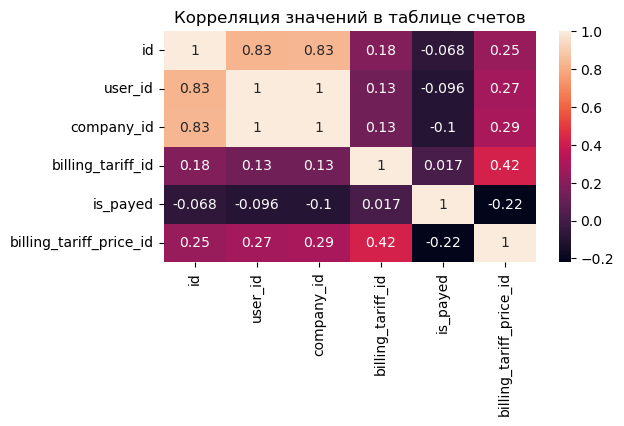

In [32]:
plt.figure(figsize=(6,3))
sns.heatmap(bill.corr(), annot=True).set(title='Корреляция значений в таблице счетов');

Видно, что есть небольшая корреляция между тарифом компаний и предложенной ценой по этим тарифом.

Посмотрим на корреляцию в таблице активностей:

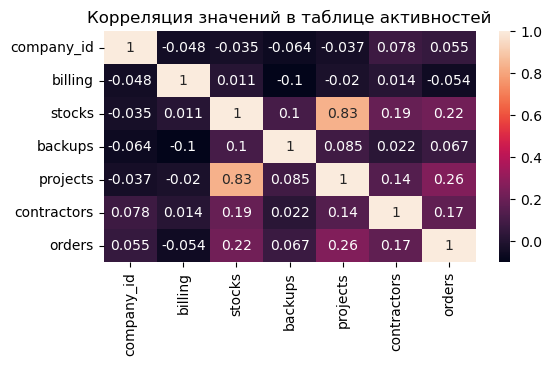

In [33]:
plt.figure(figsize=(6,3))
sns.heatmap(act.corr(), annot=True).set(title='Корреляция значений в таблице активностей');

Видно, что есть большая корреляция между количеством складов (аренда, заказы и т.д.), используемых компанией, и месячным количеством проектов компаний, что очевидно, ведь если у компании есть проект, то она с большой вероятностью будет использовать склад.

Рассмотрим количество активностей компаний по годам:

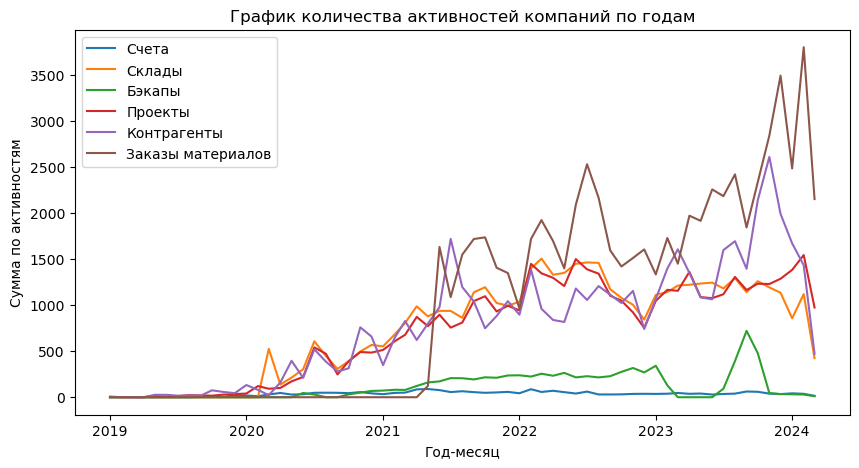

In [34]:
grouped = act.groupby(['month']).agg(billing_sum=('billing', 'sum'),
                                       stocks_sum=('stocks', 'sum'),
                                       backups_sum=('backups', 'sum'),
                                       projects_sum=('projects', 'sum'),
                                       contractors_sum=('contractors', 'sum'),
                                       orders_sum=('orders', 'sum')).reset_index()
grouped['month'] = pd.to_datetime(grouped['month'])
columns_to_plot = {
    'billing_sum': 'Счета',
    'stocks_sum': 'Склады',
    'backups_sum': 'Бэкапы',
    'projects_sum': 'Проекты',
    'contractors_sum': 'Контрагенты',
    'orders_sum': 'Заказы материалов'
}

plt.figure(figsize=(10, 5))
for column, label in columns_to_plot.items():
    sns.lineplot(data=grouped, x='month', y=column, label=label)

plt.title('График количества активностей компаний по годам')
plt.xlabel('Год-месяц')
plt.ylabel('Сумма по активностям')
plt.legend(title='')
plt.show()

Заметен большой скачок по заказам в середине 2021 года, а до этого момента значение по колонке заказов было нулевым. Вероятно, возможность оформить такую услугу как заказ материалов, стала доступна только в 2021 году. К 2024 году это остается самой популярной услугой. Линии складов и проектов почти идентичны. Почти нет активностей по бэкапам и выставлению счетов.

Соединим таблицы активностей и компаний, чтобы рассмотреть активность по каждому тарифу:

In [35]:
df = cmp.merge(act, on='company_id', how='left')

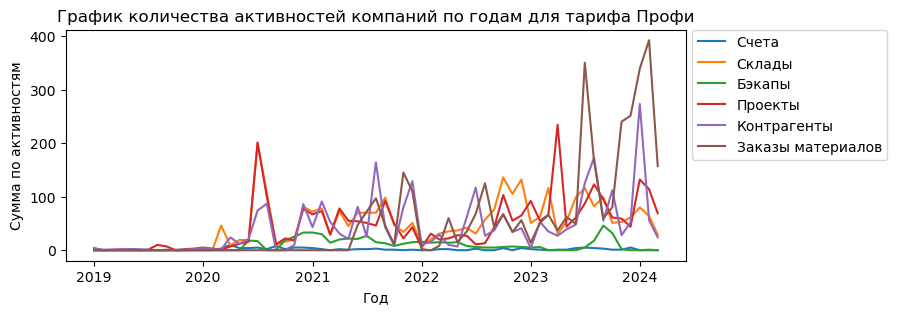

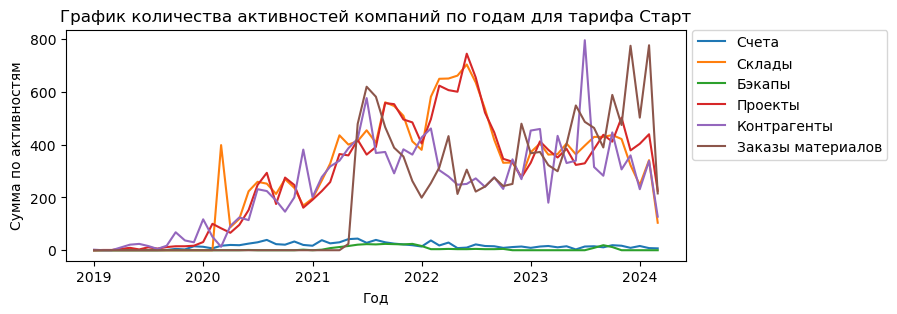

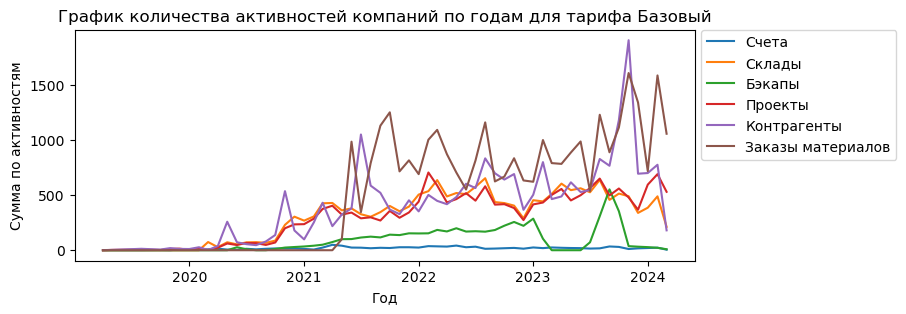

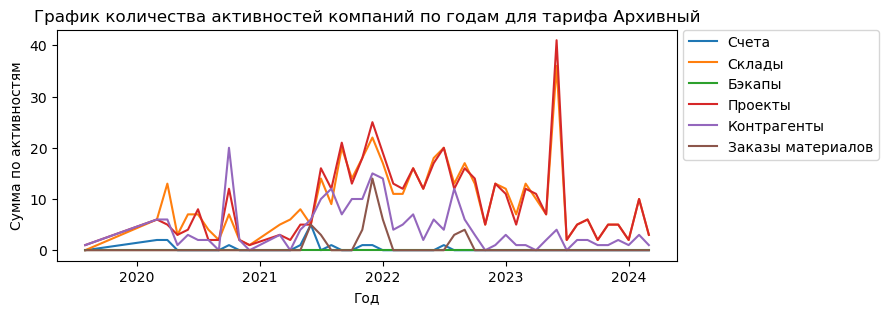

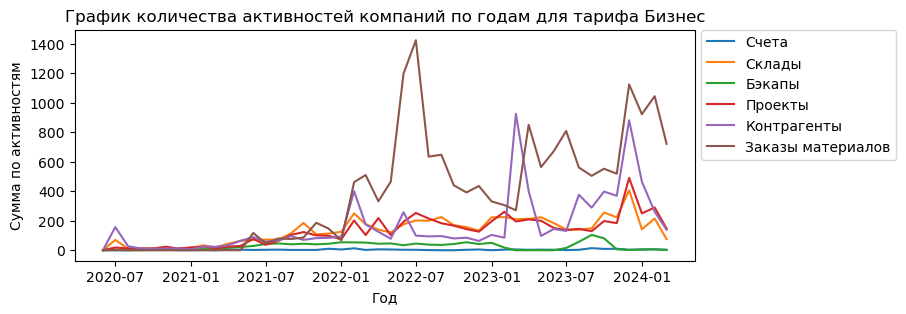

In [36]:
grouped = df.groupby(['month','tariff']).agg(billing_sum=('billing', 'sum'),
                                       stocks_sum=('stocks', 'sum'),
                                       backups_sum=('backups', 'sum'),
                                       projects_sum=('projects', 'sum'),
                                       contractors_sum=('contractors', 'sum'),
                                       orders_sum=('orders', 'sum')).reset_index()
grouped['month'] = pd.to_datetime(grouped['month'])

for tariff in grouped['tariff'].unique():
    plt.figure(figsize=(8, 3))
    for column, label in columns_to_plot.items():
        sns.lineplot(data=grouped[grouped['tariff'] == tariff], x='month', y=column, label=label)
    
    plt.title(f'График количества активностей компаний по годам для тарифа {tariff}')
    plt.xlabel('Год')
    plt.ylabel('Сумма по активностям')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., title='')
    plt.show()

- **Профи** - основная активность начала расти с 2020 года,  и к 2024 году пиковые значения имеются у таких активностей как заказ иатериалов и контрагентов.
- **Старт** - активность начала расти с 2020 года, в 2021 заметен резкий скачок по заказам материалов и далее по сумме все активности кроме выставления счетов и бэкапов держатся в районе 200-800 шт.
- **Бизнес** - только с конца 2021
- ***Базовый** - основная активность начала расти только в 2021 году, в отличие от других тарифов бэкапы росли к 2023, и был их всплеск в конце 2023 года. Суммы по складам и проектам колеблются в районе 500, но более всего у тарифа Базовый - это заказы материалов - линия колеблется в районе 500-1500.
- **Бизнес** - активность начала расти только с начала 2022 года, самый большой пик пришелся на середину 2022 года, по заказу материалов.
- Рассмотрим также **Архивный** тариф, хотя значений по нему немного, но можно видеть, что он вряд ли может называться "Архивным" - он активен с 2019 года, и остается активным до 2024. По нему не производится бэкапов, и почти нет заказов материалов, зато основная активность есть с проектами и складами - всегда в районе 10-20 штук, и пиком до 40 штук в 2023 году. 

Расмотрим также плотность распределения тарифов по годам:

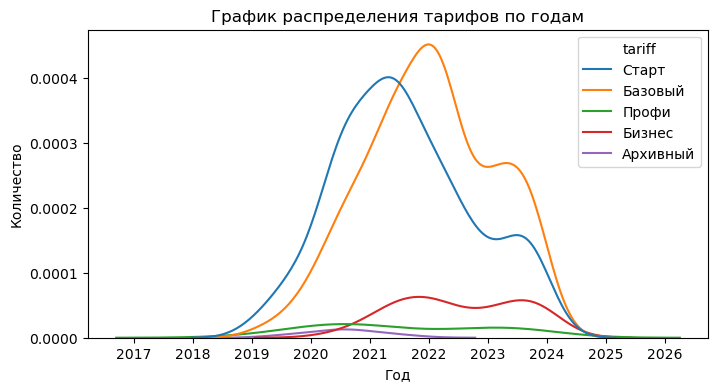

In [37]:
plt.figure(figsize=(8, 4))
sns.kdeplot(x='created_at', hue='tariff', data=cmp)
plt.title('График распределения тарифов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')

plt.show();

Наибольшее количество пользователей пришлось на 2022 год, и это пользователи с тарифами Базовый и Старт. распределение снижается к 2023 году. Создание аккаунтов с Архивным тарифом прекратилось в 2023 году, но как мы видели выше, пользователи с этим тарифом до сих пор активны.

Выделим отточных и неотточных клиентов, определим последние даты оплаты для каждого пользователя и текущую дату:

In [38]:
bill['last_date'] = bill.groupby('user_id')['payed_until'].transform('max')
analyse_date = datetime.now()

Считаем R score - количество дней между датой анализа и датой до которой оплачен сервис

In [39]:
bill['r_score'] = (analyse_date - bill['last_date']) / pd.Timedelta('1D')

Для каждой строки в r_score применяется функция, которая возвращает 0, если значение меньше нуля (то есть оплата еще активна), и 1 в противном случае (клиент ушел из сервиса).

In [40]:
bill['churn'] = bill.r_score.apply(lambda cell: 0 if cell < 0 else 1)

Корректируем значения R score - для строк, где r_score меньше нуля, значение устанавливается равным 1, что соответствует первому дню активности, чтобы учесть активность пользователя на дату анализа. И устанавливаем целочисленный тип данных.

In [41]:
bill.r_score = bill.r_score.apply(lambda cell: 1 if cell < 0 else cell)

bill.r_score = bill.r_score.astype('int')

Теперь посмотрим на выбросы:

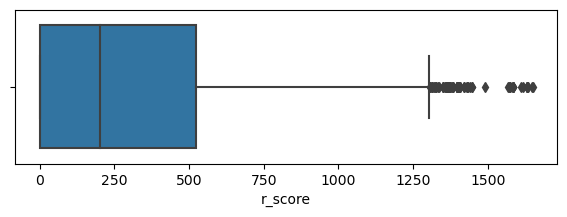

In [42]:
plt.figure(figsize=(7, 2))
sns.boxplot(bill['r_score'], orient='h');

Вычисляем первый и третий квартиль (q1 и q3) для столбца r_score, используя функцию np.percentile для вычисления 25-го и 75-го процентилей (первый и третий квартили соответственно).

In [43]:
q1, q3 = np.percentile(bill['r_score'], [25, 75])

Вычисляем разницу между третьим и первым квартилем, что дает межквартильный размах(IQR), который поможет определить границы выбросов.

In [44]:
iqr = q3 - q1

Вычисляем верхнюю границу для R-score, добавляя к третьему квартилю его межквартильный размах, умноженный на 1.5.

In [45]:
r_top = round(q3 + iqr * 1.5, 2)

Определение границ интервалов для категоризации R score:
Создается список границ интервалов r_bins, который начинается с 0, затем включает 33-й и 66-й процентили из значений r_score, которые меньше или равны r_top, и заканчивается максимальным значением r_score.

In [46]:
r_bins = [0, *np.percentile(bill[bill['r_score'] <= r_top]['r_score'], [33, 66]), bill['r_score'].max()]

Разделим датасет на 3 категории:

Создадим список меток, который содержит значения 3, 2 и 1. И используем функцию pd.cut для категоризации значений в столбце r_score по заданным границам интервалов r_bins и меткам r_labels.

In [47]:
r_labels = [3, 2, 1]
bill['R'] = pd.cut(bill['r_score'], labels=r_labels, bins=r_bins)

Визуализируем доли отточных и не отточных сегментов:

Общее количество компаний - 1841
Количество отточных компаний - 1429


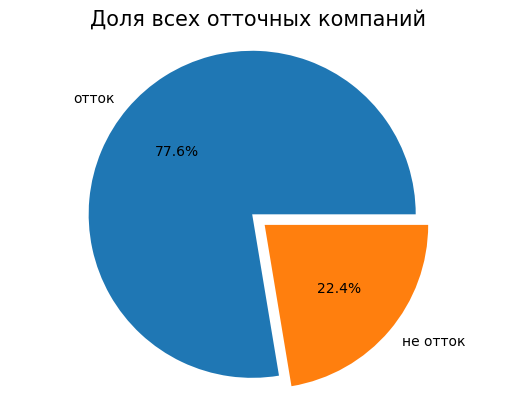

In [48]:
unique_companies = bill['company_id'].nunique()
churned_companies = bill[bill['churn']== 1]['company_id'].nunique()
churn_rate = (churned_companies / unique_companies) * 100

labels = ['отток', 'не отток']
sizes = [churn_rate, 100.0 - churn_rate]
explode = [0.1, 0]

print(f'Общее количество компаний - {unique_companies}')
print(f'Количество отточных компаний - {churned_companies}')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%')
ax1.axis('equal')
plt.title('Доля всех отточных компаний', fontsize=15)
plt.show()

В отток ушли 1419 компаний из 1841, это чуть больше 77%

Рассмотрим распределение тарифов компаний, тарифов цен и периода активности пользователей по колонке оттока `churn`:

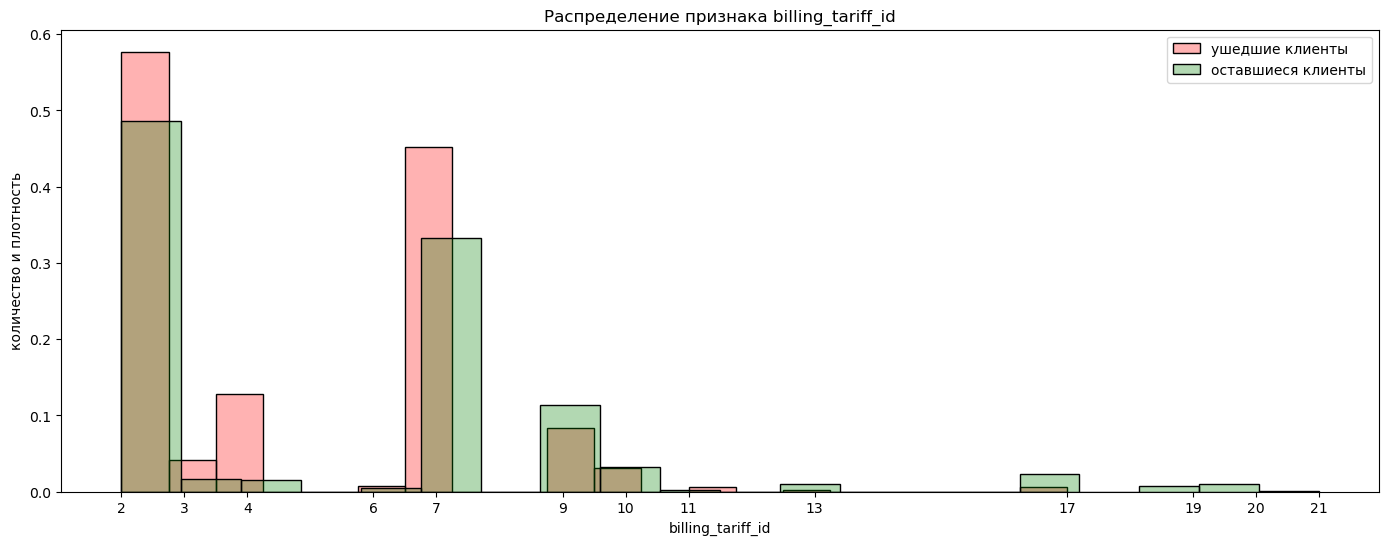

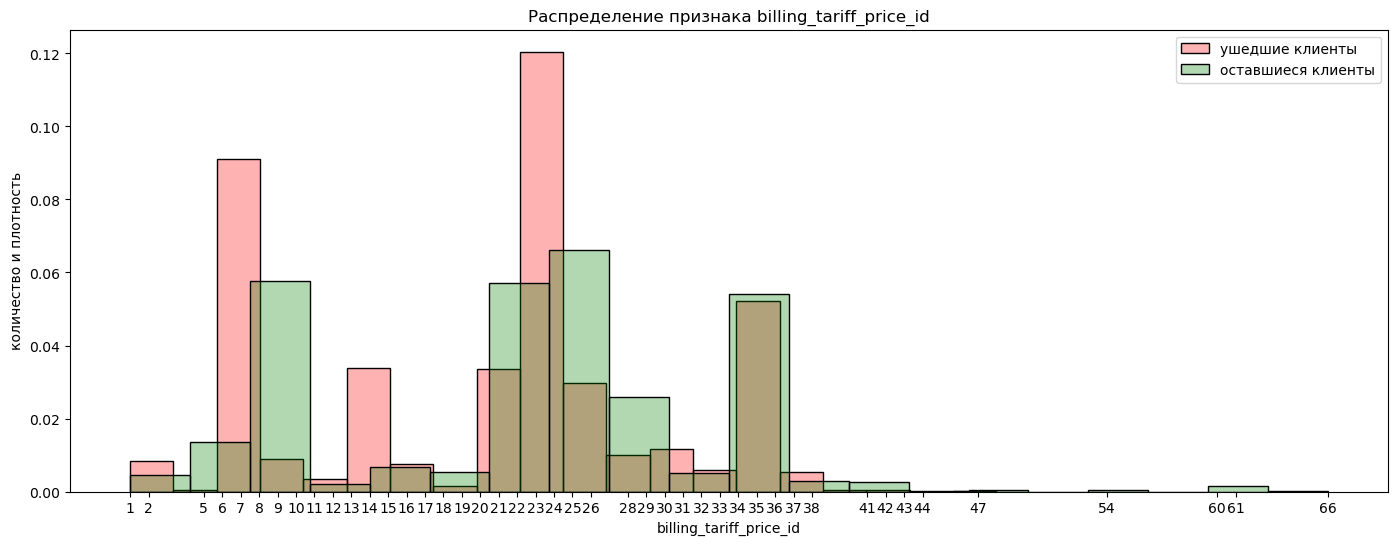

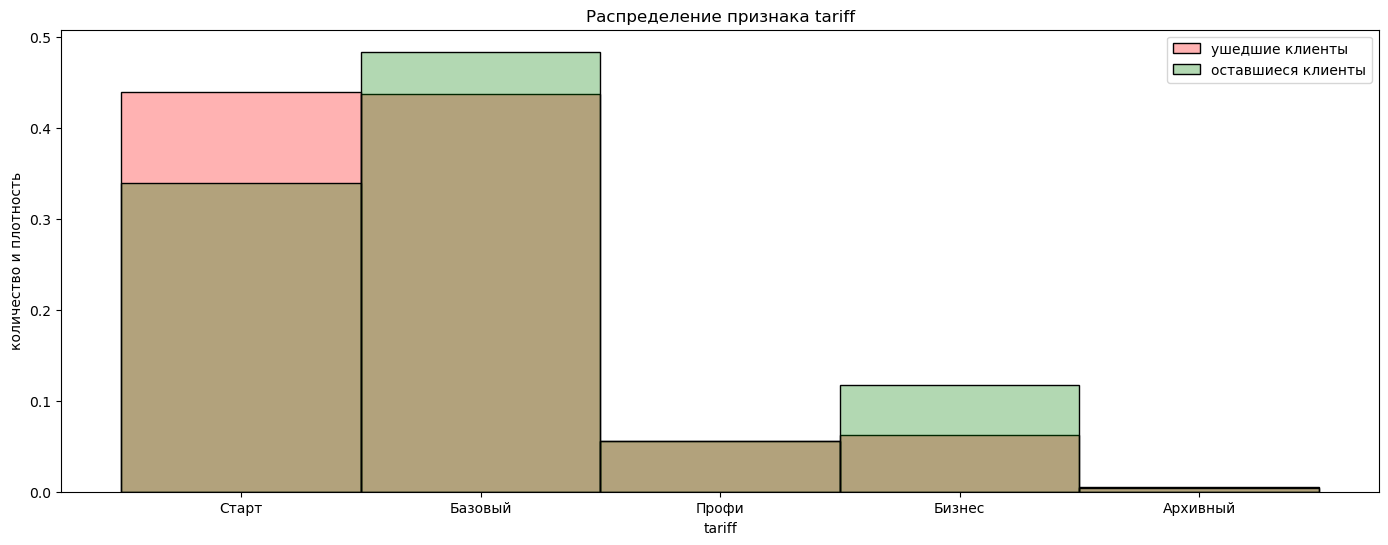

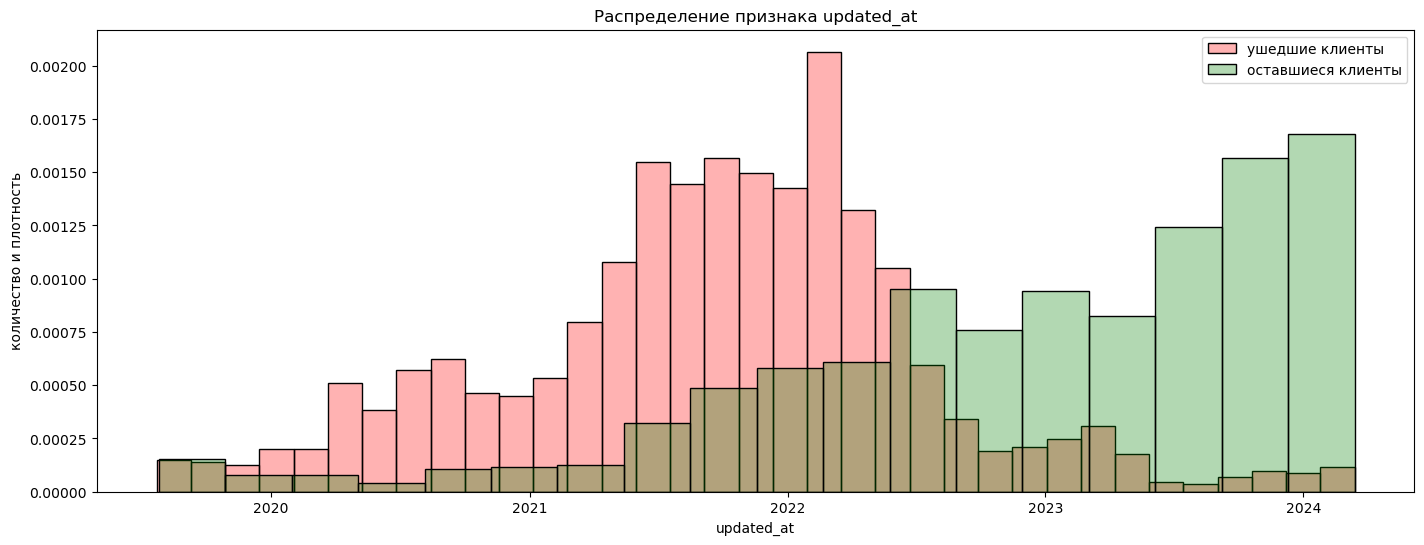

In [49]:
good = bill.query('churn == 0')
bad = bill.query('churn == 1')
for column in bill[['billing_tariff_id','billing_tariff_price_id','tariff','updated_at']].columns:
    fig, ax = plt.subplots(figsize=(17,6))
    plt.title('Распределение признака ' + column)
    plt.xlabel(column)
    plt.ylabel('количество и плотность')
    sns.histplot(bad[column], label='ушедшие клиенты',color='red', stat='density', alpha=0.3, common_norm=False)
    sns.histplot(good[column], label='оставшиеся клиенты',color='green', stat="density",alpha=0.3, common_norm=False)
    
    if column == 'updated_at':
        plt.xticks()
    else:
        plt.xticks(np.unique(good[column]))
    
    plt.legend()
    plt.show()

По колонке с тарифами наиболее отточные - пользователи с тарифами 2, 4 и 7. Также это видно по распределению типов тарифов - Базовый и Старт - самые отточные. Также видны выбивающиеся значения тарифов - 19-21 - возможно, их выбирают(либо у пользователей есть возможность их выбрать), например, в случае, если компания является крупной. 

По тарифам оплат для самых отточных пользователей стали 6-8, 13-15, 20-24. Также видны выбивающиеся значения тарифов цен в районе 47-66

По активности видно, что отточные пользователи были активнее в 2022 году, и даже был небольшой всплеск активности, но к 2024 их активность начала снижаться.

Рассмотрим подробнее активность клиентов, распределенных по нашему рейтингу в колонке `R`:

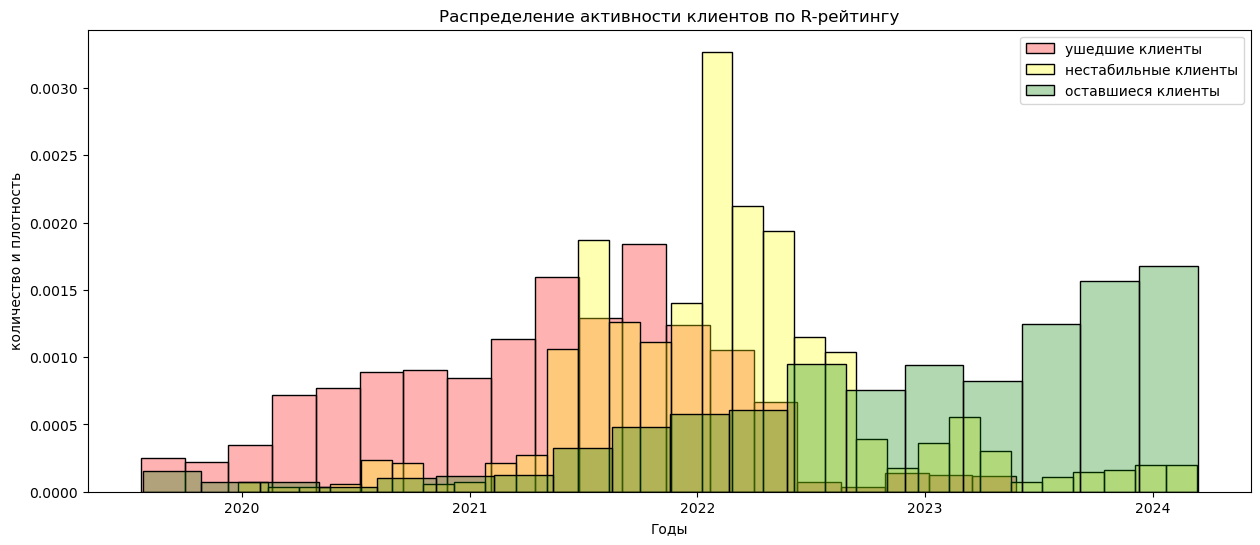

In [50]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Распределение активности клиентов по R-рейтингу' )
plt.xlabel('Годы')
plt.ylabel('количество и плотность')
sns.histplot(bill.query('R == 1')['updated_at'], label='ушедшие клиенты',
             color='red', stat='density', alpha=0.3, common_norm=False)
sns.histplot(bill.query('R == 2')['updated_at'], label='нестабильные клиенты',
             color='yellow', stat="density",alpha=0.3, common_norm=False)
sns.histplot(bill.query('R == 3')['updated_at'], label='оставшиеся клиенты',
             color='green', stat="density",alpha=0.3, common_norm=False)
plt.legend()
plt.show()

У нестабильной желтой группы пик активности пришел на 2022 год, причем этот пик не затронул оставшихся клиентов зеленой группы, что может говорить о попытке сервиса стимулировать клиентов именно этого сегмента какими-либо акциями в этот период, но к 23 году их активность продолжила снижаться. 

Отточные клиенты красной группы сначала показывали неплохую активность, но к концу 2022 года она стремительно снизилась.

Создадим датафрейм с самым отточным сегментом и создадим список с уникальными идентификаторами компаний для фильтрации других датафреймов.

In [51]:
leave = bill[bill['R'] == 1]

In [52]:
bads = leave['company_id'].unique().tolist()

Визуализируем долю самых отточных компаний по рейтингу R:

Общее количество компаний - 1841
Количество отточных компаний - 769


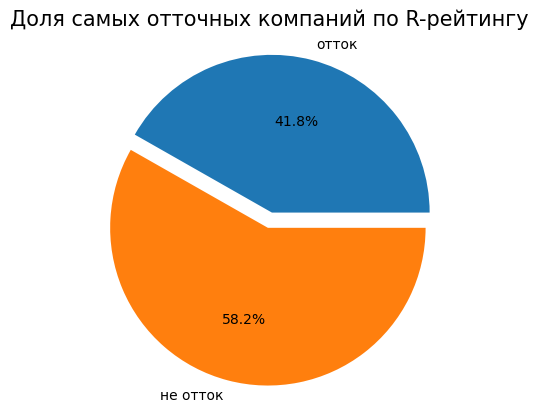

In [53]:
unique_companies = bill['company_id'].nunique()
churned_companies = leave['company_id'].nunique()
churn_rate = (churned_companies / unique_companies) * 100

labels = ['отток', 'не отток']
sizes = [churn_rate, 100.0 - churn_rate]
explode = [0.1, 0]

print(f'Общее количество компаний - {unique_companies}')
print(f'Количество отточных компаний - {churned_companies}')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%')
ax1.axis('equal')
plt.title('Доля самых отточных компаний по R-рейтингу', fontsize=15)
plt.show()

В тотальном оттоке почти половина всех компаний.

Отфильтруем наши таблицы по списку Id самых отточных компаний, и оставим только их, чтобы подробнее изучить их портрет.

In [54]:
act_filt = act[act['company_id'].isin(bads)]
cmp_filt = cmp[cmp['company_id'].isin(bads)]
ppl_filt = ppl[ppl['company_id'].isin(bads)]
df_filt = df[df['company_id'].isin(bads)]

Рассмотрим активность оттока по годам:

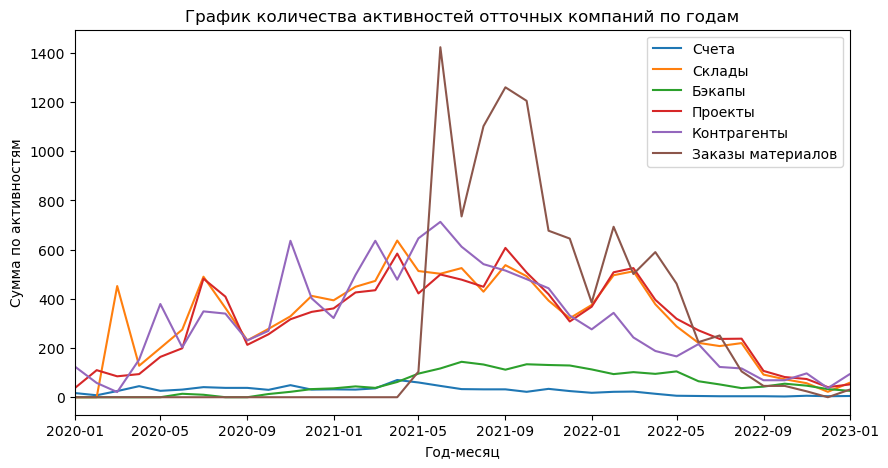

In [55]:
m_grouped = act_filt.groupby(['month']).agg(billing_sum=('billing', 'sum'),
                                       stocks_sum=('stocks', 'sum'),
                                       backups_sum=('backups', 'sum'),
                                       projects_sum=('projects', 'sum'),
                                       contractors_sum=('contractors', 'sum'),
                                       orders_sum=('orders', 'sum')).reset_index()
m_grouped['month'] = pd.to_datetime(m_grouped['month'])

plt.figure(figsize=(10, 5))
for column, label in columns_to_plot.items():
    sns.lineplot(data=m_grouped, x='month', y=column, label=label)

plt.title('График количества активностей отточных компаний по годам')
plt.xlabel('Год-месяц')
plt.ylabel('Сумма по активностям')
plt.legend(title='')
plt.xlim(datetime(2020, 1, 1), datetime(2023, 1, 1))
plt.show()

На графике видно что максимальный уровень активности пришелся на конец 2020-начало 2022 года, но с появлением услуги "Заказ материалов", вся активность начала снижаться. 

Посмотрим на распределение отточных тарифов по годам: 

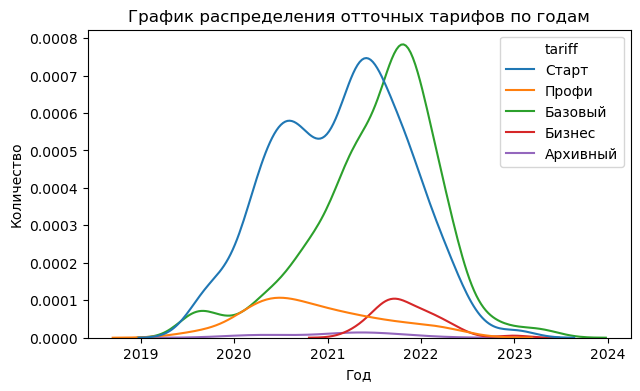

In [56]:
plt.figure(figsize=(7,4))
sns.kdeplot(x='created_at', hue='tariff', data=leave)
plt.title('График распределения отточных тарифов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show();

Пик создания таких аккаунтов пришелся на 2001-2022 год. Отточные пользователи тарифа Бизнес начали появляться только в 2021 году. Вероятно, в этот период времени пользователям этих тарифов что-то не нравилось в сервисе.

Построим графики распределения количества работников в отточных компаниях, и предлагаемых им ценовых тарифов:

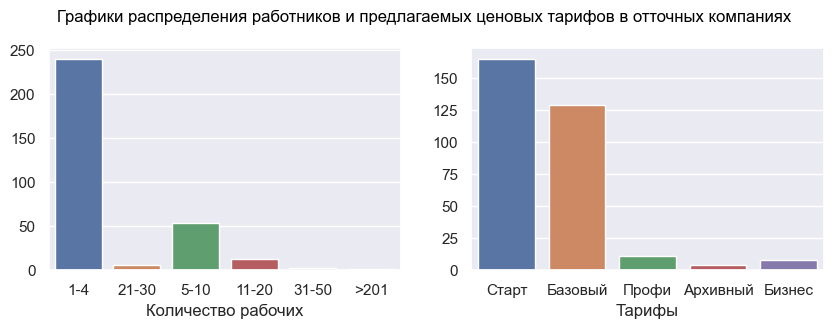

In [57]:
plt.rcParams ['figure.figsize'] = [10, 3]
plt.suptitle('Графики распределения работников и предлагаемых ценовых тарифов в отточных компаниях')
sns.set()
plt.subplots_adjust(top= 0.85 )

plt.subplot(1, 2, 1)
sns.countplot(data=cmp_filt, x='employers')
plt.title('')
plt.xlabel('Количество рабочих')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.countplot(data=cmp_filt, x='tariff')
plt.title('')
plt.xlabel('Тарифы')
plt.ylabel('');

Среди отточных компаний наибольшее количество тех, кто пользуется Стартовым и Базовым тарифом, а так же тех, у кого в штате 1-4 человек.

Пока основная гипотеза по причине ухода этих пользователей такая: Пользователям не нравятся предлагаемые цены. Рассмотрим распределение предложенных ценовых категорий для самых отточных сегментов:

In [58]:
filt = leave.merge(df_filt, on='company_id', how = 'left')

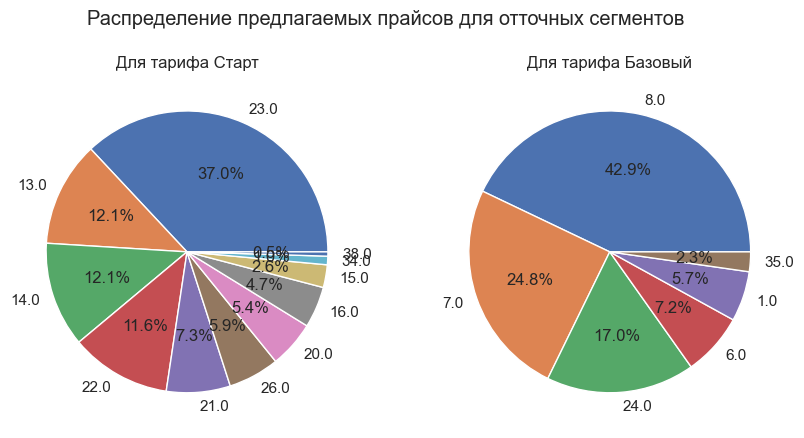

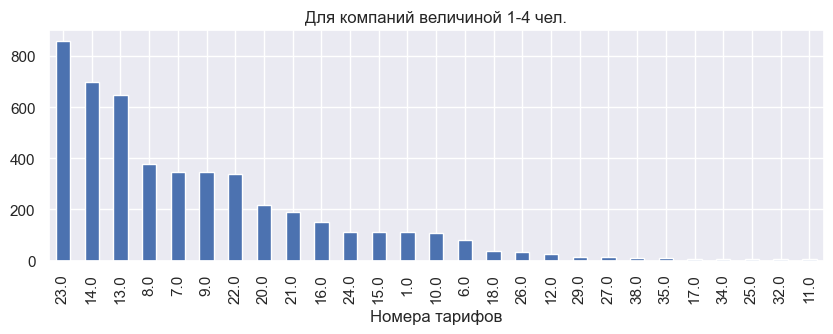

In [59]:
plt.rcParams ['figure.figsize'] = [10, 5]
plt.suptitle('Распределение предлагаемых прайсов для отточных сегментов')

plt.subplot(1, 2, 1)
leave[leave['tariff']=='Старт']['billing_tariff_price_id'].value_counts()\
.plot(kind='pie', autopct='%1.1f%%').set(ylabel='', title='Для тарифа Старт')

plt.subplot(1, 2, 2)
leave[leave['tariff']=='Базовый']['billing_tariff_price_id'].value_counts()\
.plot(kind='pie', autopct='%1.1f%%').set(ylabel='', title='Для тарифа Базовый')

plt.figure(figsize=(10, 3))
filt[filt['employers']=='1-4']['billing_tariff_price_id'].value_counts()\
.plot(kind='bar').set(xlabel='Номера тарифов', title='Для компаний величиной 1-4 чел.')

plt.show()

Проведя исследовательский анализ полученных данных, можно сформировать портрет отточных клиентов сервиса.
* Это маленькие компании, величиной 1-4 человека
* Пользуются самыми популярными тарифами сервиса - Базовый и Старт
* Основное количество этих компаний преобладало в период 2021-2023г.
* Самой часто встречающейся активностью среди этих компаний был заказ материалов
* Основными предлагаемыми ценовыми тарифами для сегментов Базовый и Старт, были номера 23 для Старт и 8 для Базовый

## Проверка гипотез<a id="stats"></a>

### Гипотеза 1:

**Н0: Отток пользователей не зависит от предложенного тарифа**

**Н1: Отток пользователей зависит от предложенного тарифа**

In [60]:
contingency_table = pd.crosstab(bill['churn'], bill['billing_tariff_price_id'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Значение статистики chi-квадрат:", chi2)
print("P-значение:", p)

alpha = 0.05
if p < alpha:
    print("Отклоняем нулевую гипотезу о независимости оттока от прайса.")
else:
    print("Подтверждаем нулевую гипотезу о независимости оттока от прайса.")

Значение статистики chi-квадрат: 312.79569555201067
P-значение: 2.316897645119404e-41
Отклоняем нулевую гипотезу о независимости оттока от прайса.


Таким образом, на основе p-значения, мы можем отклонить нулевую гипотезу о независимости, что подтверждает наличие статистически значимых различий в частотах встречающихся числовых категориальных значений между двумя группами. Это может указывать на то, что выбор тарифа оплаты влияет на вероятность оттока клиентов.

### Гипотеза 2:

**Н0: Отток пользователей не зависит от выбранного тарифа**

**Н1: Отток пользователей зависит от выбранного тарифа**

In [61]:
contingency_table = pd.crosstab(bill['churn'], bill['tariff'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Значение статистики chi-квадрат:", chi2)
print("P-значение:", p)

alpha = 0.05

if p < alpha:
    print("Отклоняем нулевую гипотезу о независимости оттока от тарифа.")
else:
    print("Подтверждаем нулевую гипотезу о независимости оттока от тарифа.")

Значение статистики chi-квадрат: 50.34774343541596
P-значение: 3.054881682433866e-10
Отклоняем нулевую гипотезу о независимости оттока от тарифа.


P-значение меньше заданного уровня значимости, что указывает на статистически значимые различия в оттоке пользователей в зависимости от размера компании. Размер компании имеет значимое влияние на вероятность оттока пользователей.

## Выводы и рекомендации<a id="end"></a>

- Максимальный уровень активности отточных компаний пришелся на конец 2020 года и начало 2022 года, после чего активность снизилась к 2023 году. Это указывает на возможные изменения в предпочтениях или условиях использования сервиса, которые могли повлиять на отток пользователей. Заметно, что активность начала снижаться после введения услуги "Заказ материалов".
- Пик создания аккаунтов отточных пользователей пришелся на период 2021-2022 годов, в то время как отточные пользователи тарифа Бизнес начали появляться только в 2021 году. Это может указывать на то, что в этот период пользователям этих тарифов что-то не нравилось в сервисе, что могло привести к их оттоку.
- Среди отточных компаний наибольшее количество тех, кто использует Стартовый и Базовый тарифы, а также тех, у кого в штате 1-4 человека. Это указывает на то, что отток может быть связан с несоответствием предлагаемых тарифов потребностям малых компаний.

Отток пользователей, особенно среди малых компаний, может быть связан с недовольством предлагаемыми ценовыми тарифами и изменениями в условиях использования сервиса. Вероятно, цены на услуги заказа материалов были слишком высокими для большинства пользователей.

Также статистически подтвердилось, что выбор тарифа оплаты может влиять на вероятность оттока клиентов, и размер компании также имеет значимое влияние на вероятность оттока пользователей.

**Рекомендации**

Остается неясным принцип выбора ценового тарифа для компаний. Их количество, а так же распределение позволяет предположить, что тарифы назначаются вручную, а для крупных компаний и прочих "особых" случаев создаются индивидуальные предложения.
Рекомендуется пересмотреть политику компаний в отношении пользователей, подходящих под портрет отточного клиента, и скорректировать систему распределения прайсов.

Также рекомендуется скорректировать и категоризировать раздел определения ролей, возможно, структурировать или сократить их количество.

Введение выбора готовых категориальных значений для раздела отрасли компаний поможет избежать разрозненной информации в этом разделе, и поможет в дальнейшем анализе и выявлении новых закономерностей.

